In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy.linalg import expm
from scipy import misc

import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

#Qiskit Set
from qiskit import BasicAer, IBMQ
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs
from qiskit.aqua.utils.dataset_helper import get_feature_dimension

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
training_size=20
test_size=10
n=6
PLOT_DATA=True

In [4]:
class_labels = [r'A', r'B']


CC_df=pd.read_csv('Credit_Card.csv', sep=',')

CC_target=CC_df['default.payment.next.month'].values
CC_df=CC_df.drop(['default.payment.next.month'], axis=1)
CC_data=CC_df.values

print(">> Shape of Credit Card dataset: "+str(CC_data.shape)+", Shape of Target: "+str(CC_target.shape))

>> Shape of Credit Card dataset: (30000, 23), Shape of Target: (30000,)


In [5]:
CC_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2,2,2,26,-1,2,0,0,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,2,2,2,34,0,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000.0,2,2,1,37,0,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


In [6]:
sample_train, sample_test, label_train, label_test = train_test_split(CC_data, CC_target, test_size=0.20, random_state=12)

print(">> Shape of sample train: "+str(sample_train.shape)+", Shape of sample test: "+str(sample_test.shape))

>> Shape of sample train: (24000, 23), Shape of sample test: (6000, 23)


In [7]:
# Now we standarize for gaussian around 0 with unit variance
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

In [8]:
sample_train[1]

array([-0.520584  , -1.24008173,  0.18590253, -1.05419699,  0.70656115,
        0.01578468,  0.11319109,  0.13764758,  0.18493656,  0.23196724,
        0.25222204,  0.66193279,  0.62406562,  0.59477358,  0.58100544,
        0.56460585,  0.4875931 , -0.13822209, -0.08239435, -0.13691494,
       -0.09968343, -0.12344716, -0.27695333])

In [9]:
sample_test[1]

array([ 0.01786839, -1.24008173,  0.18590253,  0.85890152, -0.70479695,
        0.90506247, -1.56474974, -1.53630318, -1.52447127, -1.53400063,
       -1.49477042, -0.69510131, -0.69075318, -0.67812044, -0.67269172,
       -0.66169649, -0.6522335 , -0.33477135, -0.25411943, -0.29065349,
       -0.31180365, -0.31359429, -0.29602613])

In [10]:
# Now reduce number of features to number of qubits
pca = PCA(n_components=n).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

print(">> Shape of reduced sample train: "+str(sample_train.shape)+", Shape of reduced sample test: "+str(sample_test.shape))

>> Shape of reduced sample train: (24000, 6), Shape of reduced sample test: (6000, 6)


In [11]:
pca

PCA(n_components=6)

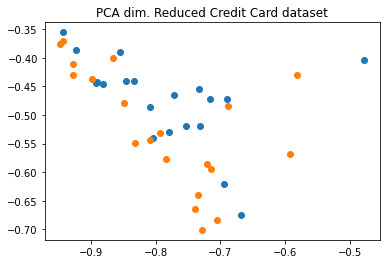

In [12]:
# Scale to the range (-1,+1)
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Pick training size number of samples from each distro
training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
test_input = {key: (sample_test[label_test == k, :])[:test_size] for k, key in enumerate(class_labels)}

if PLOT_DATA:
    for k in range(0, 2):
        plt.scatter(
            sample_train[label_train == k, 0][:training_size],
            sample_train[label_train == k, 1][:training_size]
        )

    plt.title("PCA dim. Reduced Credit Card dataset")
    plt.show()

#return sample_train, training_input, test_input, class_labels

In [13]:
# Working on QC

In [14]:
seed = 10599

# feature_map = SecondOrderExpansion(feature_dimension=n, depth=1, entanglement='linear')
feature_map = ZZFeatureMap(feature_dimension=n, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input)

backend = BasicAer.get_backend('qasm_simulator')
#backend = IBMQ.get_backend('ibmq_5_yorktown')

print("Running on device: ", backend)

# quantum_instance = QuantumInstance(backend, shots=1024, seed=seed, seed_transpiler=seed)
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=aqua_globals.random_seed, seed_transpiler=aqua_globals.random_seed)

result = qsvm.run(quantum_instance)


/home/sushant/Documents/mysoft/anaconda3/envs/vqiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/classifiers/qsvm/qsvm.py:104: DeprecationWarning: The package qiskit.aqua.algorithms.classifiers is deprecated. It was moved/refactored to qiskit_machine_learning.algorithms.classifiers (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-machine-learning')
/home/sushant/Documents/mysoft/anaconda3/envs/vqiskit/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.aqua_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  del sys.path[0]
/home/sushant/Documents/mysoft/anaconda3/envs/vqiskit/lib/python3.7/site-packages/qiskit/aqua/quantum_instance.py:137: DeprecationWarning: The class qiskit

Running on device:  qasm_simulator


2021-04-18 20:54:29,575:qiskit.aqua.algorithms.classifiers.qsvm.qsvm:DEBUG: Calculating overlap:
|██████████████████████████████████████████████████| 780/780 [00:00:00:00]
2021-04-18 20:54:52,223:qiskit.aqua.utils.qp_solver:DEBUG: Solving QP problem is completed.
2021-04-18 20:55:17,786:qiskit.aqua.algorithms.classifiers.qsvm.qsvm:DEBUG: Calculating overlap:
|██████████████████████████████████████████████████| 460/460 [00:00:00:00]
2021-04-18 20:55:26,006:qiskit.aqua.algorithms.classifiers.qsvm._qsvm_binary:DEBUG: Classification success for this set is 70.00% 



In [15]:
print("Testing success ratio: {}".format(result['testing_accuracy']))


Testing success ratio: 0.7
